In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import bmxobs
from matplotlib.colors import LogNorm
from scipy.optimize import least_squares
from scipy.optimize import basinhopping
%matplotlib inline

In [2]:
# d1 = bmxobs.BMXObs("pas/210603_0600", channels="120,130,230,560,570,580,670,680,780")

# d1 = bmxobs.BMXObs("pas/210615_0500", channels="120,130,230,560,570,580,670,680,780")
# d2 = bmxobs.BMXObs("pas/210614_0500", channels="120,130,230,560,570,580,670,680,780")
# d3 = bmxobs.BMXObs("pas/210615_0500", channels="120,130,230,560,570,580,670,680,780")
# d4 = bmxobs.BMXObs("pas/210617_0500", channels="120,130,230,560,570,580,670,680,780")

# d1 = bmxobs.BMXObs("pas/210714_0300", channels="120,130,230,560,570,580,670,680,780")
# d1 = bmxobs.BMXObs("pas/190425_0800", channels="120,130,230,560,570,580,670,680,780")
# d1 = bmxobs.BMXObs("pas/210626_0400", channels="120,130,230,560,570,580,670,680,780")

In [2]:
def get_cross_cut (D, fmin, fmax, ravg=10, ramin = 5.23-0.1, ramax=5.23+0.1, chan=120):
    freqcut = np.where((D.freq[0]>fmin) & (D.freq[0]<fmax))[0]
    data = D[chan][:,freqcut]
    # average in freq
    data = data.mean(axis=1)
    racut = np.where((D.ra>ramin) & (D.ra<=ramax))[0]
    racut = racut[:len(racut)//ravg*ravg]
    # average in ra
    data = data[racut]
    data=data.reshape((-1,ravg)).mean(axis=1)
    ra = D.ra[racut].reshape((-1,ravg)).mean(axis=1) 
    ra = np.unique(ra, axis = 0)
    return ra,data/1e11
    

In [4]:
ra, data = get_cross_cut(d1,1103,1107, chan=120)
ra2, data2 = get_cross_cut(d1,1103,1107, chan=130)
ra3, data3 = get_cross_cut(d1,1103,1107, chan=230)
ra4, data4 = get_cross_cut(d1,1103,1107, chan=560)
ra5, data5 = get_cross_cut(d1,1103,1107, chan=570)
ra6, data6 = get_cross_cut(d1,1103,1107, chan=580)
ra7, data7 = get_cross_cut(d1,1103,1107, chan=670)
ra8, data8 = get_cross_cut(d1,1103,1107, chan=680)
ra9, data9 = get_cross_cut(d1,1103,1107, chan=780)

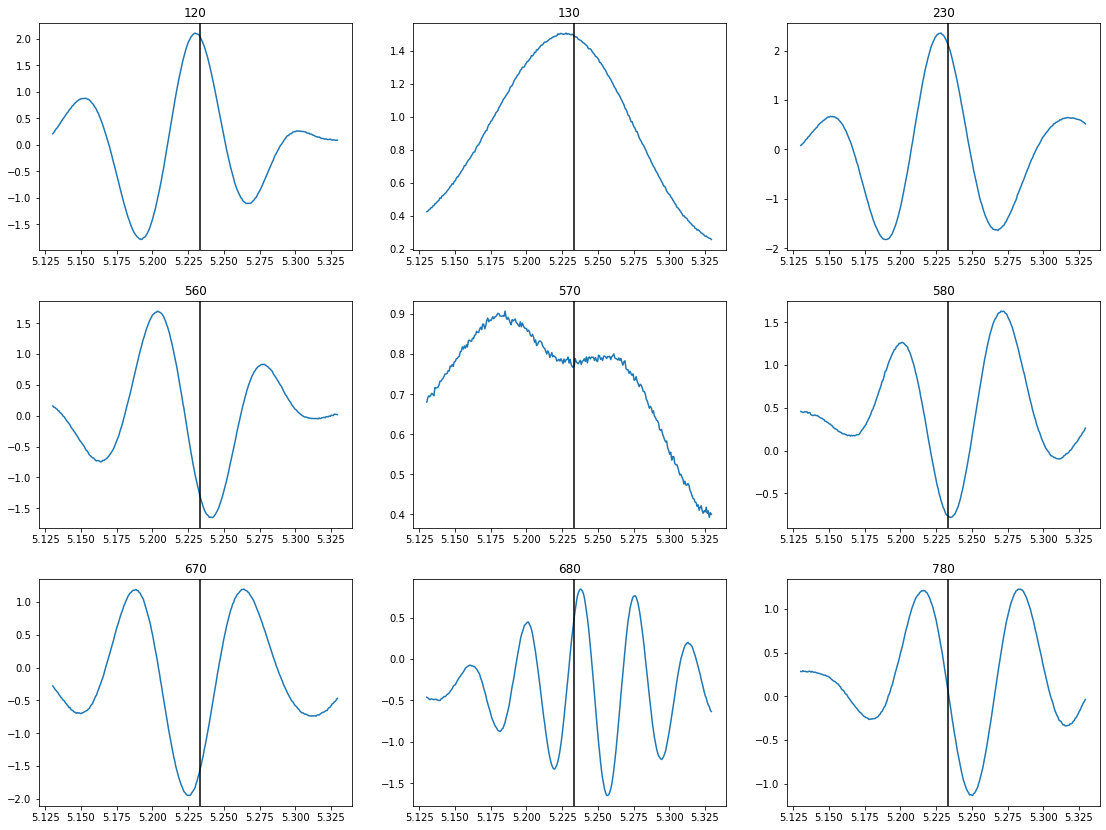

In [5]:
# plt.plot(ra,np.imag(data))
# plt.plot(ra,np.real(data))
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16,12))
fig.tight_layout(pad=3)
ind = np.array([[120, 130, 230],[560, 570, 580],[670, 680, 780]])

set_data = np.array([[np.real(data), np.real(data2), np.real(data3)], 
                     [np.real(data4), np.real(data5), np.real(data6)], 
                     [np.real(data7), np.real(data8), np.real(data9)]])

set_ra = np.array([[ra, ra2, ra3], [ra4, ra5, ra6], [ra7, ra8, ra9]])

for row in range(3):
    for col in range(3):
        axes[row][col].plot(set_ra[row][col], set_data[row][col])
        
        axes[row][col].axvline(5.233, color = 'black')
        axes[row][col].set_title('{}'.format(ind[row][col]))

In [3]:
class Fitter:
    def __init__ (self, ra, data):
        self.ra = ra
        self.data = data
        self.cyg_ra = 5.233
        
    def minimize(self, startguess):
        self.startfitmodel = self.cross_model(*startguess)
        #sol = least_squares(self._residuals, startguess, method='lm',xtol=1e-2)
        sol = minimize(self.chi2, startguess,method='powell')
        #sol = basinhopping(self.chi2, startguess)
        self.bestfit = sol.x
        self.bestchi2 = self.chi2(sol.x)
        self.bestfitmodel = self.cross_model(*sol.x)
        return self.bestchi2
    
    def robust_minimize(self, sfreq=60):
        Aguess = np.abs(self.data).max()
        guess = [self.cyg_ra, 0.0, 0.0, Aguess, 0, 0, .025]
        bestchi2 = 1e6
        for phase in np.arange(8)*2*np.pi/8:
            for freq in np.linspace(sfreq-20, sfreq+20,5):
                guess[4:6] = phase, freq
                chi2=self.minimize(guess)
#                 print (f"{phase:.3e} {freq:.3e} chi2 = {chi2}")
                if chi2<bestchi2:
                    bestchi2 = chi2
                    bestfit = self.bestfit
        
        self.bestchi2 = bestchi2
        self.bestfit= bestfit
        self.bestfitmodel = self.cross_model(*self.bestfit)
        
    def chi2_2 (self,x):
        guess = self.startguess
        guess[4:6] = x
        chi2 = self.chi2(guess)
            #print (x,'{0:.16f}'.format(chi2))
        return self.chi2(guess)
        
    def minimize2 (self, startguess):
        self.startguess=startguess
        
        sol = basinhopping(self.chi2_2, startguess[4:6])
        return sol.x
    
    def _residuals (self, x):
        model = self.cross_model(*x)
        diff = model-self.data
        diffreal = np.hstack((np.real(diff), np.imag(diff)))
        #print (x,np.sum(diffreal**2))
        return np.real(diff)
    
    
    def cross_model(self, ra0, ofsreal, ofsimag, A, phi, omega, sigma):
        return ofsreal+1j*ofsimag+A*np.exp(-1j*(phi+omega*(self.ra-self.cyg_ra)))*np.exp(-(self.ra-ra0)**2/(2*sigma**2))

    def chi2(self,x):
        model = self.cross_model(*x)
        diff = self.data-model
        chi2 = (np.real(diff)**2).sum()+(np.imag(diff)**2).sum()
        #print(chi2)
        return chi2

In [4]:
def process_data(date_id):
    d = bmxobs.BMXObs(date_id, channels="120,130,230,560,570,580,670,680,780")
    chan = np.array([120,130,230,560,570,580,670,680,780])
    freqs = np.array([60, 40, -60, 60, 20, -60, -40, -125, -40])
    f = np.zeros(9, dtype=Fitter)
    f_robmin = np.zeros((9, 40))
    bestfit = np.zeros((9, 7))
    chisq = np.zeros(9)
    
    set_data = np.zeros((9, 2, 140))
    set_ra = np.zeros((9, 140))
    set_fit = np.zeros((9, 2, 140))
    
    for i in range(len(chan)):
        ra, data = get_cross_cut(d, 1448, 1452, ramin = 5.23-0.05, ramax=5.23+0.05, chan=chan[i])
#         print(len(data))
        set_data[i] = np.array([np.imag(data), np.real(data)])
        set_ra[i] = ra
        
        f[i] = Fitter(ra, data)
        f_robmin[i] = f[i].robust_minimize(sfreq=freqs[i])
        bestfit[i] = f[i].bestfit
        chisq[i] = f[i].bestchi2
        
        set_fit[i] = np.array([np.imag(f[i].bestfitmodel), np.real(f[i].bestfitmodel)])

    fig, axes = plt.subplots(nrows = 9, ncols = 2, figsize=(10,15))
    fig.tight_layout(pad = 3)
    ind = np.array([['120_i', '120_real'], ['130_i', '130_real'], ['230_i', '230_real'],
               ['560_i', '560_real'], ['570_i', '570_real'], ['580_i', '580_real'],
               ['670_i', '670_real'], ['680_i', '680_real'], ['780_i', '780_real']])
    
#     print(f_robmin)
    for row in range(9):
        for col in range(2):
            axes[row][col].plot(set_ra[row], set_data[row][col])
            axes[row][col].plot(set_ra[row], set_fit[row][col])

            axes[row][col].axvline(5.233, color = 'black')
            axes[row][col].set_title('{}'.format(ind[row][col]))

    plt.suptitle('CygA transit {}, freq = 1450'.format(date_id), size = 15, y = 1)
    
    outfile = open(date_id+'_1450.results','wb')
    pickle.dump(bestfit, outfile)
    outfile.close()
    plt.savefig(date_id+'_1450.png')

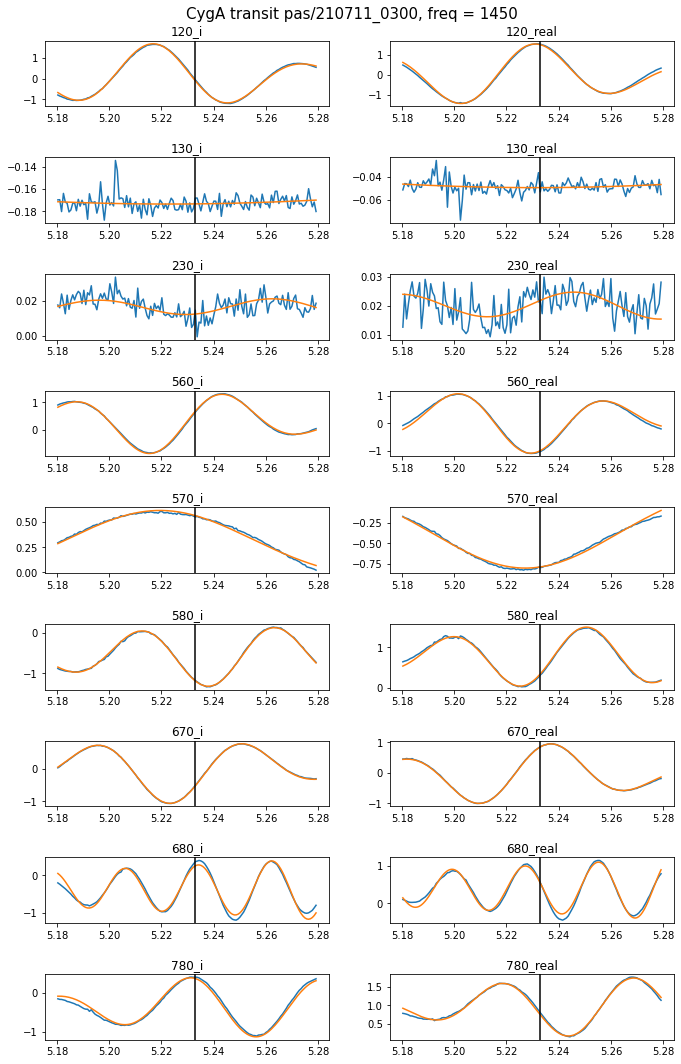

In [84]:
# process_data('pas/210613_0500')
# process_data('pas/210614_0500')
# process_data('pas/210615_0500')
# process_data('pas/210617_0500')

# process_data('pas/210709_0300')
# process_data('pas/210710_0300')
process_data('pas/210711_0300')
# process_data('pas/210714_0300')

# process_data('pas/210625_0400')
# process_data('pas/210626_0400')
# process_data('pas/210627_0400')
# process_data('pas/210628_0400')

# process_data('pas/210529_0600')
# process_data('pas/210530_0600')
# process_data('pas/210531_0600')
# process_data('pas/210603_0600')

In [31]:
d1 = pickle.load(open('pas/210613_0500.results', 'rb'))
d2 = pickle.load(open('pas/210614_0500.results', 'rb'))
d3 = pickle.load(open('pas/210615_0500.results', 'rb'))
d4 = pickle.load(open('pas/210617_0500.results', 'rb'))

day = [d1, d2, d3, d4]
day_names = [210613, 210614, 210615, 210617]
# chi2 = np.array([d1[1], d2[1], d3[1], d4[1]])
B = np.array([120, 130, 230, 560, 570, 580, 670, 680, 780])
# vals = f.bestfit
names = 'ra0, ofsreal, ofsimag, A, phi, omega, sigma'.split()

# for i in range(4):
#     print('**Day: {}**'.format(day_names[i]))
#     for j in range(9):
#         print('Baseline = {}'.format(B[j]))
#         for n,v in zip(names,day[i][j]):
#             print (f"{n} = {v:.3e}")
# #         print ("chi2=", chi2[j])
#         print('')

In [33]:
fig, axes = plt.subplots(nrows=9, ncols=2, figsize=(10,15))
fig.tight_layout(pad=2)
ind = np.array([['120_i', '120_real'], ['130_i', '130_real'], ['230_i', '230_real'],
               ['560_i', '560_real'], ['570_i', '570_real'], ['580_i', '580_real'],
               ['670_i', '670_real'], ['680_i', '680_real'], ['780_i', '780_real']])

set_data = np.array([[np.imag(data), np.real(data)],[np.imag(data2), np.real(data2)],[np.imag(data3), np.real(data3)],
                    [np.imag(data4), np.real(data4)],[np.imag(data5), np.real(data5)],[np.imag(data6), np.real(data6)],
                    [np.imag(data7), np.real(data7)],[np.imag(data8), np.real(data8)],[np.imag(data9), np.real(data9)]])

set_fit = np.array([[np.imag(f.bestfitmodel), np.real(f.bestfitmodel)],[np.imag(f2.bestfitmodel), np.real(f2.bestfitmodel)],[np.imag(f3.bestfitmodel), np.real(f3.bestfitmodel)],
                   [np.imag(f4.bestfitmodel), np.real(f4.bestfitmodel)],[np.imag(f5.bestfitmodel), np.real(f5.bestfitmodel)],[np.imag(f6.bestfitmodel), np.real(f6.bestfitmodel)],
                   [np.imag(f7.bestfitmodel), np.real(f7.bestfitmodel)],[np.imag(f8.bestfitmodel), np.real(f8.bestfitmodel)],[np.imag(f9.bestfitmodel), np.real(f9.bestfitmodel)]])

set_ra = np.array([ra, ra2, ra3, ra4, ra5, ra6, ra7, ra8, ra9])

for row in range(9):
    for col in range(2):
        axes[row][col].plot(set_ra[row], set_data[row][col])
        axes[row][col].plot(set_ra[row], set_fit[row][col])
        
        axes[row][col].axvline(5.233, color = 'black')
        axes[row][col].set_title('{}'.format(ind[row][col]))

plt.suptitle('CygA transit 210615, freq = 1105', size = 15, y = 1)

In [7]:
class Conversion:
    def __init__(self, ra_cygA, freq):
        self.ra_cygA = 5.233
        self.freq = freq
        
    def baseline_length(self, omega):
        '''solves for our b value using our omega value'''
        lam = 3e8 / self.freq
        return (omega*lam/(2*np.pi))/np.cos(40.869/(180)*np.pi)
    
    def sig_to_deg(self, sig_rad):
        '''converts our sigma value from radians to deg'''
        return (sig_rad*(180/np.pi))*np.cos(40.869/(180)*np.pi)
    
    def ra0_to_deg(self, beam):
        '''converts our ra0 offset to degrees'''
        diff = self.ra_cygA - beam
        return diff*(180/np.pi)
    
    def triangle_sums(self, vals, ind1, ind2, ind3):
        b_sum = self.baseline_length(vals[ind1][5]) + self.baseline_length(vals[ind2][5]) + self.baseline_length(vals[ind3][5])
        return b_sum

In [34]:
# isn't finished editing

conv = Conversion(5.233, 1105e6)
ind = np.array([[0, 2, 1], [3, 6, 4], [3, 7, 5], [6, 8, 7], [4, 8, 5]])
blines = ['12, 23, 13', '56, 67, 57', '56, 68, 58', '67, 78, 68', '57, 78, 68']
b_arr = np.zeros(9)
print('Conversions:')
for i in range(len(day)):
    b = conv.baseline_length(day[i][5]) # basline length - units: m
    sig = conv.sig_to_deg(day[i][6])
    ra0 = conv.ra0_to_deg(day[i][0])
    b_arr[i] = b
    
    print('Baseline = {}'.format(B[i]))
    print('ra0 (deg): ', ra0)
    print('sigma (deg): ', sig)
    print('baseline length: ', b)
    print('')
    
# for i in range(9):
#     print()
#     print(B[i], ': ', b_arr[i])
    
# print('Triangle Sums:')
# for i in range(5):
#     print('Baseline: {}'.format(blines[i]))
#     print(conv.triangle_sums(vals_arr, *ind[i]))
#     print('')

In [14]:
d1 = pickle.load(open('pas/210613_0500_1450.results', 'rb'))
d2 = pickle.load(open('pas/210614_0500_1450.results', 'rb'))
d3 = pickle.load(open('pas/210615_0500_1450.results', 'rb'))
d4 = pickle.load(open('pas/210617_0500_1450.results', 'rb'))

d5 = pickle.load(open('pas/210709_0300_1450.results', 'rb'))
d6 = pickle.load(open('pas/210710_0300_1450.results', 'rb'))
d7 = pickle.load(open('pas/210711_0300_1450.results', 'rb'))
d8 = pickle.load(open('pas/210714_0300_1450.results', 'rb'))

d9 = pickle.load(open('pas/210625_0400_1450.results', 'rb'))
d10 = pickle.load(open('pas/210626_0400_1450.results', 'rb'))
d11 = pickle.load(open('pas/210627_0400_1450.results', 'rb'))
d12 = pickle.load(open('pas/210628_0400_1450.results', 'rb'))

d13 = pickle.load(open('pas/210529_0600_1450.results', 'rb'))
d14 = pickle.load(open('pas/210530_0600_1450.results', 'rb'))
d15 = pickle.load(open('pas/210531_0600_1450.results', 'rb'))
d16 = pickle.load(open('pas/210603_0600_1450.results', 'rb'))

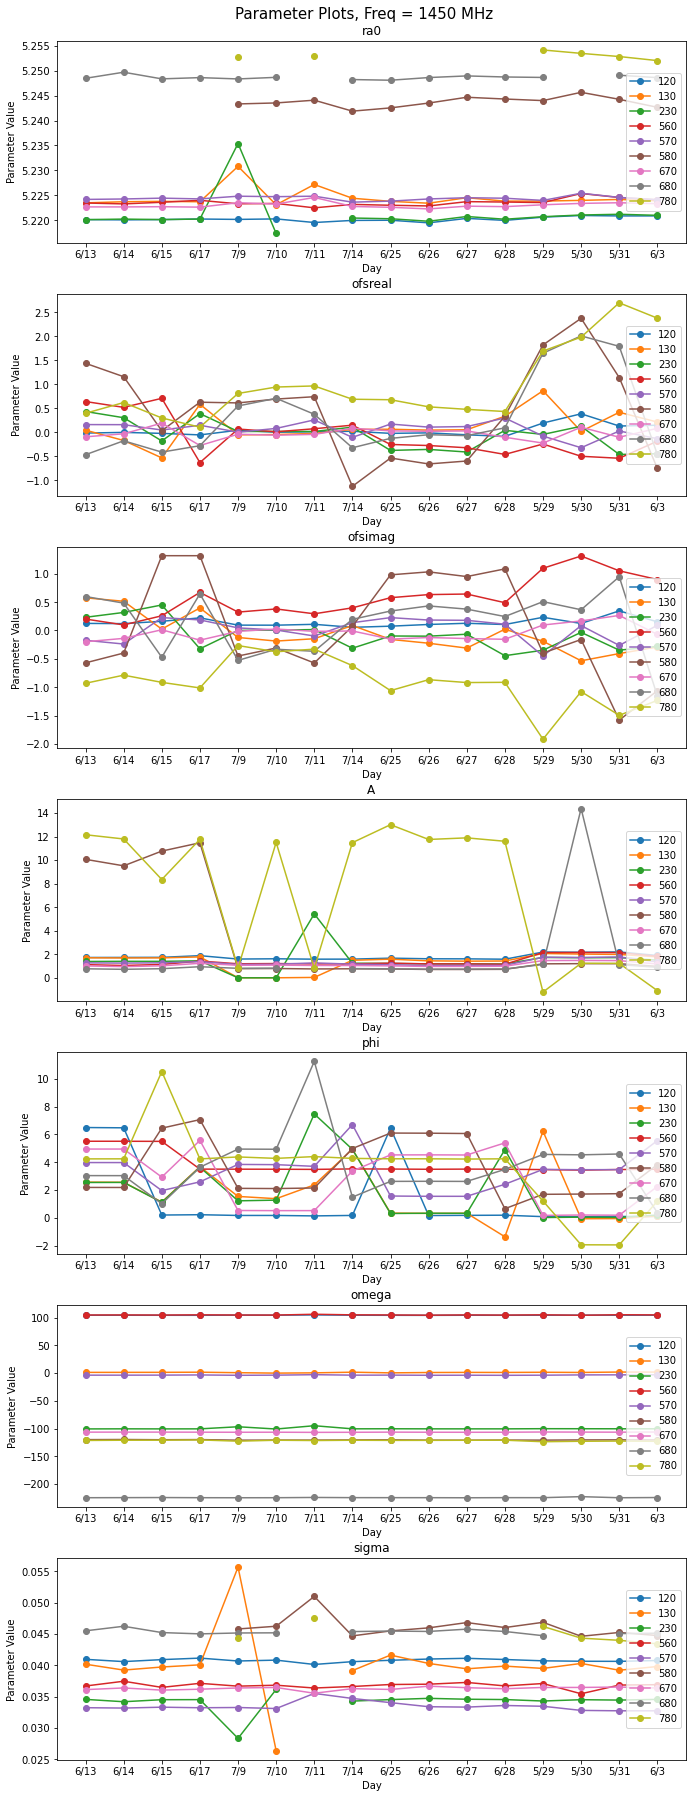

In [12]:
x = ['6/13','6/14','6/15','6/17','7/9','7/10','7/11','7/14','6/25','6/26','6/27','6/28','5/29','5/30','5/31','6/3']

vals_all = np.array([[d1[0], d2[0], d3[0], d4[0], d5[0], d6[0], d7[0], d8[0], d9[0],d10[0],d11[0],d12[0],d13[0],d14[0],d15[0],d16[0]], 
                     [d1[1], d2[1], d3[1], d4[1], d5[1], d6[1], d7[1], d8[1], d9[1],d10[1],d11[1],d12[1],d13[1],d14[1],d15[1],d16[1]], 
                     [d1[2], d2[2], d3[2], d4[2], d5[2], d6[2], d7[2], d8[2], d9[2],d10[2],d11[2],d12[2],d13[2],d14[2],d15[2],d16[2]], 
                     [d1[3], d2[3], d3[3], d4[3], d5[3], d6[3], d7[3], d8[3], d9[3],d10[3],d11[3],d12[3],d13[3],d14[3],d15[3],d16[3]], 
                     [d1[4], d2[4], d3[4], d4[4], d5[4], d6[4], d7[4], d8[4], d9[4],d10[4],d11[4],d12[4],d13[4],d14[4],d15[4],d16[4]], 
                     [d1[5], d2[5], d3[5], d4[5], d5[5], d6[5], d7[5], d8[5], d9[5],d10[5],d11[5],d12[5],d13[5],d14[5],d15[5],d16[5]], 
                     [d1[6], d2[6], d3[6], d4[6], d5[6], d6[6], d7[6], d8[6], d9[6],d10[6],d11[6],d12[6],d13[6],d14[6],d15[6],d16[6]], 
                     [d1[7], d2[7], d3[7], d4[7], d5[7], d6[7], d7[7], d8[7], d9[7],d10[7],d11[7],d12[7],d13[7],d14[7],d15[7],d16[7]],
                     [d1[8], d2[8], d3[8], d4[8], d5[8], d6[8], d7[8], d8[8], d9[8],d10[8],d11[8],d12[8],d13[8],d14[8],d15[8],d16[8]]])

names = ['ra0', 'ofsreal', 'ofsimag', 'A', 'phi', 'omega', 'sigma']
B = np.array([120, 130, 230, 560, 570, 580, 670, 680, 780])

fig, ax = plt.subplots(nrows = 7, figsize = (10, 25))
fig.tight_layout(pad=3)

for i in range(9):
    for j in range(7):
        vals_all[i][:,6] = np.abs(vals_all[i][:,6])
        for k in range(16):
            if vals_all[i][:,6][k] > 0.1: vals_all[i][:,6][k] = np.nan
            if vals_all[i][:,0][k] > 5.5 or vals_all[i][:,0][k] < 5.0: vals_all[i][:,0][k] = np.nan
            if vals_all[i][:,3][k] > 20: vals_all[i][:,3][k] = np.nan
            
        ax[j].plot(x, vals_all[i][:,j], 'o-', label = B[i])
        ax[j].set_title(names[j])
        ax[j].set_xlabel('Day')
        ax[j].set_ylabel('Parameter Value')
        ax[j].legend(loc = 'right')
plt.suptitle('Parameter Plots, Freq = 1450 MHz', y = 1, size = 15)
plt.savefig('1450_param_plots.png')

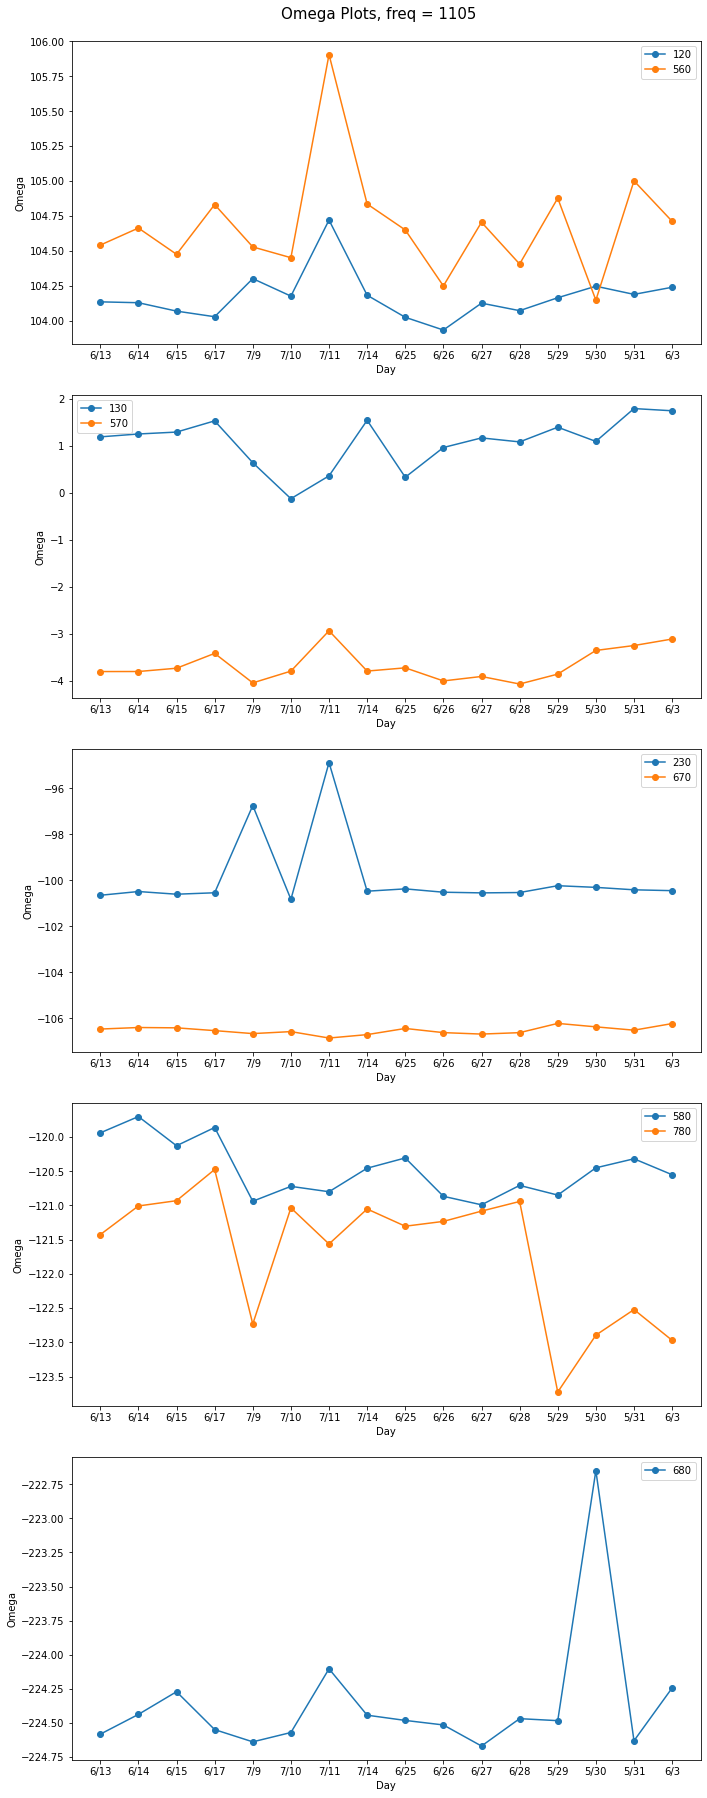

In [15]:
fig, ax = plt.subplots(nrows = 5, figsize = (10, 25))
fig.tight_layout(pad=3)

vals12_56 = np.array([vals_all[0], vals_all[3]])
vals13_57 = np.array([vals_all[1], vals_all[4]])
vals23_67 = np.array([vals_all[2], vals_all[6]])
vals58_78 = np.array([vals_all[5], vals_all[8]])

B1 = [120, 560]
B2 = [130, 570]
B3 = [230, 670]
B4 = [580, 780]

for i in range(2):
    ax[0].plot(x, vals12_56[i][:,5], 'o-', label = B1[i])
    ax[1].plot(x, vals13_57[i][:,5], 'o-', label = B2[i])
    ax[2].plot(x, vals23_67[i][:,5], 'o-', label = B3[i])
    ax[3].plot(x, vals58_78[i][:,5], 'o-', label = B4[i])

ax[4].plot(x, vals_all[7][:,5], 'o-', label = '680')
for j in range(5):
    ax[j].set_xlabel('Day')
    ax[j].set_ylabel('Omega')
    ax[j].legend()

plt.suptitle('Omega Plots, freq = 1105', size = 15, y = 1)
plt.savefig('omega_plots.png')

Text(0.5, 1.01, 'Omega Error')

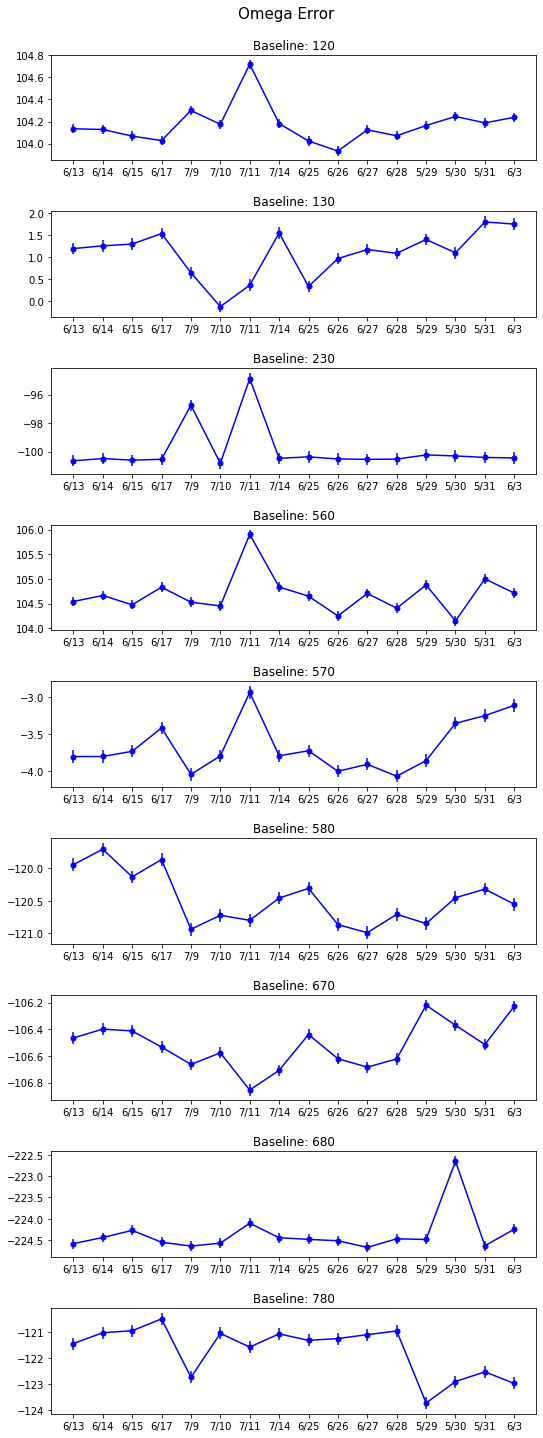

In [17]:
# error = [np.sqrt(val.var()/len(val)) for val in vals_all]
# print(error)

# for i in range(9):
#     print('Baseline: ', B[i])
#     for j in range(16):
#         print(vals_all[i][j][5], ' +/- ', error[i])

error = np.zeros((9,16))
for i in range(9):
    for j in range(16):
        error[i][j] = vals_all[i][j][5]
    error[i] = np.sqrt(np.var(error[i])/len(error[i]))
# print(error)
fig, ax = plt.subplots(nrows = 9, figsize = (8, 20))
fig.tight_layout(pad=3)
for i in range(9):
    y = vals_all[i][:,5]
    ax[i].plot(x, y, 'b.', markersize = 10)
    ax[i].errorbar(x, y, error[i], color = 'blue')
    ax[i].set_title('Baseline: {}'.format(B[i]))
plt.suptitle('Omega Error', size = 15, y = 1.01)